# CNN classification on melspectograms for native language identification

This approach is taken from this [article](https://medium.com/@hasithsura/audio-classification-d37a82d6715).
We use different approaches:
 - Train a CNN from scratch.
 - Retrained a pretrained ResNet34.
 - Augment data by partitioning the 45 second utterances into 5 second utterances.

In [1]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score

In [2]:
folder_path = 'C:/native_language/wav/'

In [3]:
wav, sr = librosa.load(folder_path+'train_0001.wav', sr=None)
print(f'Sampling rate of the audio is {sr} Hz and length of the audio is {len(wav)/sr} seconds')

Sampling rate of the audio is 16000 Hz and length of the audio is 46.8 seconds


In [4]:
wav.shape

(748800,)

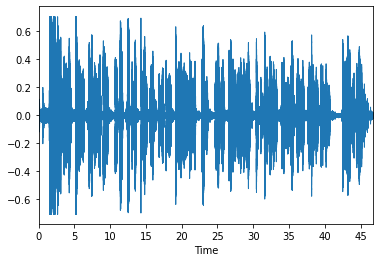

In [5]:
librosa.display.waveplot(wav, sr)

In [6]:
class CNN(nn.Module):
    def __init__(self, input_shape, batch_size=16, num_cats=11):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size = 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn8 = nn.BatchNorm2d(256)
        self.dense1 = nn.Linear(256*(((input_shape[1]//2)//2)//2)*(((input_shape[2]//2)//2)//2),500)
        self.dropout = nn.Dropout(0.5)
        self.dense2 = nn.Linear(500, num_cats)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = F.max_pool2d(x, kernel_size=2) 
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv5(x)
        x = F.relu(self.bn5(x))
        x = self.conv6(x)
        x = F.relu(self.bn6(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv7(x)
        x = F.relu(self.bn7(x))
        x = self.conv8(x)
        x = F.relu(self.bn8(x))
        x = x.view(x.size(0),-1)
        x = F.relu(self.dense1(x))
        x = self.dropout(x)
        x = self.dense2(x)
        return x

In [7]:
def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled

In [10]:
"""def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=64, fmin=20, fmax=8300, top_db=80):
    wav,sr = librosa.load(file_path,sr=sr)

    if wav.shape[0]<5*sr:
        wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
    else:
        wav=wav[2*sr:20*sr]
        spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
                                            hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
        spec_db=librosa.power_to_db(spec,top_db=top_db)
    return spec_db""";

In [11]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=64, fmin=20, fmax=8300, top_db=80,
                         index=1):
    LAST = 40  # Only take samples up until the 40th second (to avoid samples shorter than that)
    wav,sr = librosa.load(file_path,sr=sr)

    if wav.shape[0]<5*sr:
        wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
    else:
        wav=wav[(5*index)*sr:(5*(index+1))*sr]
        spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
                                            hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
        spec_db=librosa.power_to_db(spec,top_db=top_db)
    return spec_db

C:\Users\Alberto\anaconda3\envs\native-language-identification\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\Alberto\anaconda3\envs\native-language-identification\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


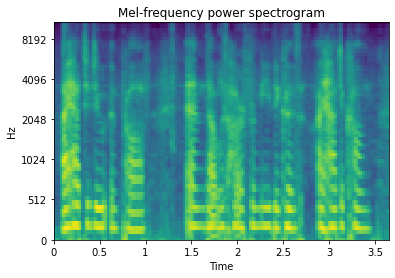

In [12]:
librosa.display.specshow(spec_to_image(get_melspectrogram_db(folder_path+'train_0001.wav', sr)), cmap='viridis',
                        x_axis='time', y_axis='mel')
plt.title('Mel-frequency power spectrogram')
plt.savefig('spectogram.png', dpi=300)

In [13]:
input_size = spec_to_image(get_melspectrogram_db(folder_path+'train_0001.wav', sr)).shape
input_size

(64, 157)

In [19]:
label_file = "C:/native_language/lab/ComParE2016_Nativeness.tsv"
label_file_test = "C:/native_language/lab/ComParE2016_Nativeness-test.tsv"

In [15]:
data_file = pd.read_csv(label_file, sep="\t")
data_file.tail()

,file_name,promptId,L1
4260,devel_0961.wav,P7,CHI
4261,devel_0962.wav,P7,FRE
4262,devel_0963.wav,P7,GER
4263,devel_0964.wav,P6,FRE
4264,devel_0965.wav,P5,GER


In [16]:
train_files = data_file['file_name'].str.contains('train')
train_df = data_file[train_files]
train_df.tail()

,file_name,promptId,L1
3295,train_3296.wav,P1,TEL
3296,train_3297.wav,P2,TUR
3297,train_3298.wav,P7,SPA
3298,train_3299.wav,P1,CHI
3299,train_3300.wav,P5,KOR


In [17]:
dev_files = data_file['file_name'].str.contains('devel')
dev_df = data_file[dev_files]
dev_df.tail()

,file_name,promptId,L1
4260,devel_0961.wav,P7,CHI
4261,devel_0962.wav,P7,FRE
4262,devel_0963.wav,P7,GER
4263,devel_0964.wav,P6,FRE
4264,devel_0965.wav,P5,GER


In [23]:
data_file_test = pd.read_csv(label_file_test, sep="\t")
data_file_test.tail()

,file_name,L1
862,test_0863.wav,KOR
863,test_0864.wav,KOR
864,test_0865.wav,GER
865,test_0866.wav,ITA
866,test_0867.wav,ARA


In [25]:
test_files = data_file_test['file_name'].str.contains('test')
test_df = data_file_test[test_files]
test_df.tail()

,file_name,L1
862,test_0863.wav,KOR
863,test_0864.wav,KOR
864,test_0865.wav,GER
865,test_0866.wav,ITA
866,test_0867.wav,ARA


In [29]:
train_df = pd.concat([train_df, dev_df])

In [30]:
len(train_df), len(test_df)

(4265, 867)

In [31]:
class Data(Dataset):
    def __init__(self, df, base='C:/native_language/wav/', in_col='file_name', out_col='L1'):
        self.df = df
        self.data = []
        self.labels = []
        self.c2i={}
        self.i2c={}
        self.categories = sorted(df[out_col].unique())
        for i, category in enumerate(self.categories):
            self.c2i[category]=i
            self.i2c[i]=category

        for ind in range(len(df)):
            row = df.iloc[ind]
            file_path = os.path.join(base,row[in_col])
            label = row[out_col]
            for j in range(1, 8): # until 40 seconds
                self.data.append(spec_to_image(get_melspectrogram_db(file_path, index=j))[np.newaxis,...])
                self.labels.append(self.c2i[row[out_col]])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [32]:
train_data = Data(train_df, base='C:/native_language/wav/',
                  in_col='file_name', out_col='L1')

In [33]:
test_data = Data(test_df, base='C:/native_language/wav/',
                  in_col='file_name', out_col='L1')

In [35]:
len(train_data.labels)

29855

In [36]:
BATCH_SIZE = 32

In [38]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [39]:
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device=torch.device('cpu')

In [40]:
#device=torch.device('cpu')

In [75]:
n_cats = 11
model = CNN(input_shape=(1, input_size[0], input_size[1]), batch_size=BATCH_SIZE, 
            num_cats=n_cats).to(device)

In [76]:
def setlr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

In [77]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 15 #30
train_losses = []
valid_losses = []

In [78]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
    for epoch in range(1,epochs+1):
        model.train()
        batch_losses=[]
        if change_lr:
            optimizer = change_lr(optimizer, epoch)
        for i, data in enumerate(train_loader):
            x, y = data
            optimizer.zero_grad()
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            
            loss = loss_fn(y_hat, y)
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()
        train_losses.append(batch_losses)
        print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1]):.3f}')
        model.eval()
        batch_losses=[]
        trace_y = []
        trace_yhat = []
        for i, data in enumerate(valid_loader):
            x, y = data
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            trace_y.append(y.cpu().detach().numpy())
            trace_yhat.append(y_hat.cpu().detach().numpy())      
            batch_losses.append(loss.item())

        valid_losses.append(batch_losses)
        trace_y = np.concatenate(trace_y)
        trace_yhat = np.concatenate(trace_yhat)
        accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
        print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1]):.3f} Valid-Accuracy : {accuracy:.3f}')

In [79]:
def lr_decay(optimizer, epoch):
    if epoch % 5 == 0:
        new_lr = learning_rate / (10**(epoch//20))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer

In [80]:
train(model, loss_fn, train_loader, test_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

Epoch - 1 Train-Loss : 2.281
Epoch - 1 Valid-Loss : 2.134 Valid-Accuracy : 0.241
Epoch - 2 Train-Loss : 2.098
Epoch - 2 Valid-Loss : 2.019 Valid-Accuracy : 0.271
Epoch - 3 Train-Loss : 1.968
Epoch - 3 Valid-Loss : 1.985 Valid-Accuracy : 0.283
Epoch - 4 Train-Loss : 1.842
Epoch - 4 Valid-Loss : 1.998 Valid-Accuracy : 0.289
Changed learning rate to 2e-05
Epoch - 5 Train-Loss : 1.695
Epoch - 5 Valid-Loss : 1.963 Valid-Accuracy : 0.303
Epoch - 6 Train-Loss : 1.549
Epoch - 6 Valid-Loss : 1.970 Valid-Accuracy : 0.303
Epoch - 7 Train-Loss : 1.392
Epoch - 7 Valid-Loss : 1.927 Valid-Accuracy : 0.324
Epoch - 8 Train-Loss : 1.227
Epoch - 8 Valid-Loss : 1.926 Valid-Accuracy : 0.333
Epoch - 9 Train-Loss : 1.050
Epoch - 9 Valid-Loss : 2.008 Valid-Accuracy : 0.315
Changed learning rate to 2e-05
Epoch - 10 Train-Loss : 0.880
Epoch - 10 Valid-Loss : 1.983 Valid-Accuracy : 0.331
Epoch - 11 Train-Loss : 0.722
Epoch - 11 Valid-Loss : 2.122 Valid-Accuracy : 0.307
Epoch - 12 Train-Loss : 0.580
Epoch - 12 Va

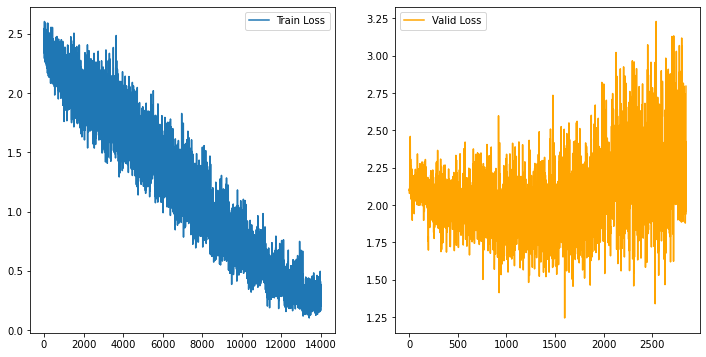

In [81]:
tl = np.asarray(train_losses).ravel()
vl = np.asarray(valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])
#plt.savefig('CNN_60epochs.png')

In [82]:
def predict(net, loader):
    net.eval()
    pred_lst = []
    true_lst = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device, dtype=torch.float32), y.to(device, dtype=torch.long)
            out = net(x)
            _, pred = torch.max(out.data, 1)
            pred_lst.extend(pred.cpu())
            true_lst.extend(y.cpu())
    return pred_lst, true_lst

In [83]:
def plot_confusion_mat(net, loader, normalize=True):
    fmt='d'
    pred_lst, true_lst = predict(net, loader)
    cf = confusion_matrix(true_lst, pred_lst)
    if normalize:
        cf = cf / cf.sum(axis=1, keepdims=True)
        fmt='.2f'
    sns.heatmap(cf, annot=True, xticklabels=train_data.categories,
               yticklabels=train_data.categories, fmt=fmt, cmap=plt.cm.Blues)
    
    return cf

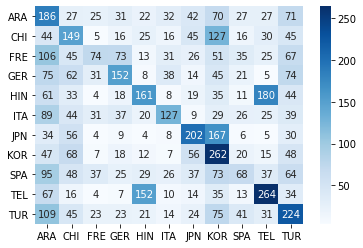

In [88]:
cf_dev = plot_confusion_mat(model, test_loader, normalize=False)
plt.savefig("confusion_mat_test_CNN_augmented.png", dpi=300)

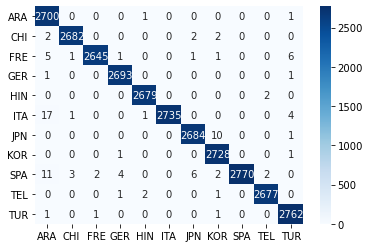

In [87]:
cf_train = plot_confusion_mat(model, train_loader, normalize=False)

In [89]:
def uar(net, loader):
    pred_lst, true_lst = predict(net, loader)
    return recall_score(true_lst, pred_lst, average='macro')

In [ ]:
train_uar = uar(model, train_loader)
test_uar = uar(model, test_loader)

In [92]:
train_uar, test_uar

(0.9966777813269285, 0.3050038821715208)

In [ ]:
# Save model
#torch.save(model.state_dict(), 'CNN_60epochs')
#del model
"""
model = CNN(input_shape=(1, 64, 563), batch_size=BATCH_SIZE, 
            num_cats=n_cats).to(devce)
model.load_state_dict(torch.load('CNN_60epochs'))
#model.eval()
"""

## Pretrained ResNet34

In [93]:
from torchvision.models import resnet34
resnet_model = resnet34(pretrained=True)
resnet_model.fc = nn.Linear(512, n_cats)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

In [95]:
learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 15
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]
def lr_decay(optimizer, epoch):
    if epoch%10==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer
train(resnet_model, loss_fn, train_loader, test_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)

Epoch - 1 Train-Loss : 2.157
Epoch - 1 Valid-Loss : 2.110 Valid-Accuracy : 0.267
Epoch - 2 Train-Loss : 1.882
Epoch - 2 Valid-Loss : 2.037 Valid-Accuracy : 0.315
Epoch - 3 Train-Loss : 1.651
Epoch - 3 Valid-Loss : 2.017 Valid-Accuracy : 0.327
Epoch - 4 Train-Loss : 1.404
Epoch - 4 Valid-Loss : 1.991 Valid-Accuracy : 0.355
Epoch - 5 Train-Loss : 1.097
Epoch - 5 Valid-Loss : 2.304 Valid-Accuracy : 0.330
Epoch - 6 Train-Loss : 0.751
Epoch - 6 Valid-Loss : 2.558 Valid-Accuracy : 0.334
Epoch - 7 Train-Loss : 0.470
Epoch - 7 Valid-Loss : 2.870 Valid-Accuracy : 0.344
Epoch - 8 Train-Loss : 0.321
Epoch - 8 Valid-Loss : 3.285 Valid-Accuracy : 0.325
Epoch - 9 Train-Loss : 0.239
Epoch - 9 Valid-Loss : 3.562 Valid-Accuracy : 0.342
Changed learning rate to 2e-05
Epoch - 10 Train-Loss : 0.070
Epoch - 10 Valid-Loss : 3.813 Valid-Accuracy : 0.359
Epoch - 11 Train-Loss : 0.023
Epoch - 11 Valid-Loss : 4.152 Valid-Accuracy : 0.364
Epoch - 12 Train-Loss : 0.012
Epoch - 12 Valid-Loss : 4.328 Valid-Accuracy

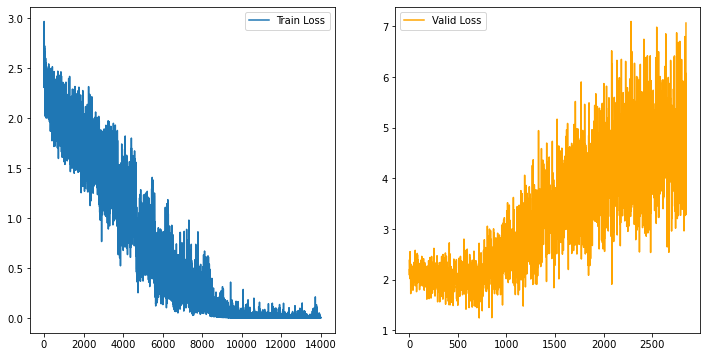

In [96]:
tl = np.asarray(resnet_train_losses).ravel()
vl = np.asarray(resnet_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])
#plt.savefig('ResNet_50epochs.png')

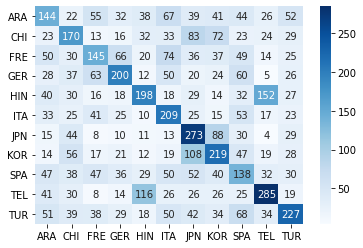

In [100]:
cf_dev = plot_confusion_mat(resnet_model, test_loader, normalize=False)
plt.savefig("confusion_mat_test_ResNet_augmented.png", dpi=300)

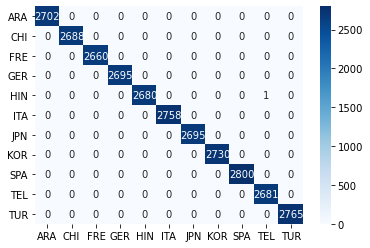

In [101]:
cf_train = plot_confusion_mat(resnet_model, train_loader, normalize=False)

In [102]:
train_uar = uar(resnet_model, train_loader)
dev_uar = uar(resnet_model, test_loader)
train_uar, test_uar

(0.9999660913499034, 0.3050038821715208)

In [ ]:
# Save model
#torch.save(resnet_model.state_dict(), 'ResNet_50epochs')
#del resnet_model

"""
from torchvision.models import resnet34
resnet_model = resnet34(pretrained=True)
resnet_model.fc = nn.Linear(512, n_cats)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

resnet_model.load_state_dict(torch.load('ResNet_50epochs'))
#resnet_model.eval()
"""

## CNN with L2 regularization

In [103]:
del model, resnet_model

In [104]:
model = CNN(input_shape=(1, input_size[0], input_size[1]), batch_size=BATCH_SIZE, 
            num_cats=n_cats).to(device)

In [105]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate,
                      weight_decay=0.001)
epochs = 15
train_losses = []
valid_losses = []

In [109]:
train(model, loss_fn, train_loader, test_loader, epochs, optimizer, 
      train_losses, valid_losses, lr_decay)

Epoch - 1 Train-Loss : 2.273
Epoch - 1 Valid-Loss : 2.160 Valid-Accuracy : 0.229
Epoch - 2 Train-Loss : 2.091
Epoch - 2 Valid-Loss : 2.059 Valid-Accuracy : 0.259
Epoch - 3 Train-Loss : 1.955
Epoch - 3 Valid-Loss : 1.999 Valid-Accuracy : 0.282
Epoch - 4 Train-Loss : 1.821
Epoch - 4 Valid-Loss : 2.009 Valid-Accuracy : 0.293
Epoch - 5 Train-Loss : 1.677
Epoch - 5 Valid-Loss : 2.040 Valid-Accuracy : 0.292
Epoch - 6 Train-Loss : 1.529
Epoch - 6 Valid-Loss : 1.976 Valid-Accuracy : 0.305
Epoch - 7 Train-Loss : 1.367
Epoch - 7 Valid-Loss : 1.984 Valid-Accuracy : 0.310
Epoch - 8 Train-Loss : 1.192
Epoch - 8 Valid-Loss : 2.025 Valid-Accuracy : 0.314
Epoch - 9 Train-Loss : 1.026
Epoch - 9 Valid-Loss : 1.989 Valid-Accuracy : 0.320
Changed learning rate to 2.0000000000000003e-06
Epoch - 10 Train-Loss : 0.788
Epoch - 10 Valid-Loss : 1.959 Valid-Accuracy : 0.337
Epoch - 11 Train-Loss : 0.754
Epoch - 11 Valid-Loss : 1.971 Valid-Accuracy : 0.335
Epoch - 12 Train-Loss : 0.727
Epoch - 12 Valid-Loss : 1.9

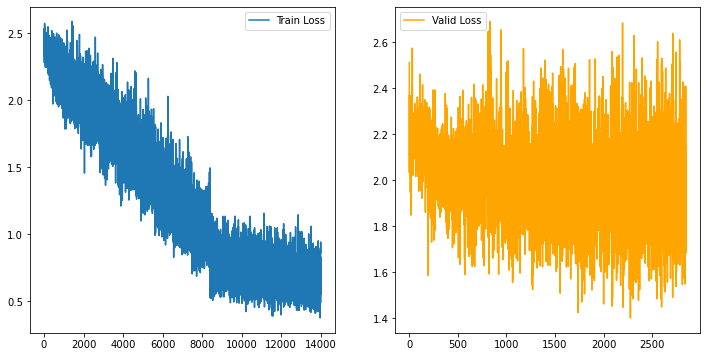

In [110]:
tl = np.asarray(train_losses).ravel()
vl = np.asarray(valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])
#plt.savefig('CNN_L2_50epochs.png')

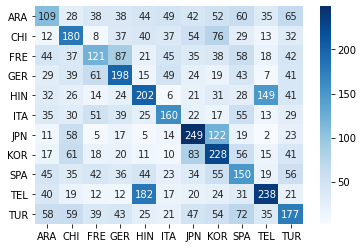

In [112]:
cf_dev = plot_confusion_mat(model, test_loader, normalize=False)

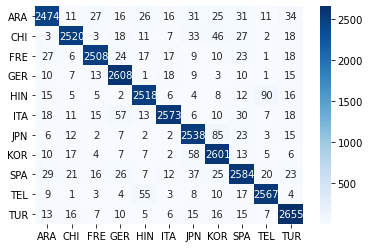

In [113]:
cf_train = plot_confusion_mat(model, train_loader, normalize=False)

In [114]:
train_uar = uar(model, train_loader)
dev_uar = uar(model, test_loader)
train_uar, test_uar

(0.9428055740591873, 0.3050038821715208)